# 目的
我们的目标是最小化分拣中心在30天内各个班次所需的正式工和临时工的总人数。

# 参数
- **正式工的数量上限**：每个班次中可用的正式工人数固定为60人。
- **正式工和临时工的工作效率**：
  - 正式工的工作效率为每小时处理25单位货物。
  - 临时工的工作效率为每小时处理20单位货物。

# 变量
- **正式工人数**：每个班次安排的正式工人数。
- **临时工人数**：每个班次安排的临时工人数。

# 约束条件
- **货物处理需求**：在每个班次中，安排的正式工和临时工必须足以处理该班次预测的总货物量。
- **正式工数量限制**：在每个班次中安排的正式工人数不能超过60人。
- **非负约束**：
  - 正式工人数 ≥ 0。
  - 临时工人数 ≥ 0。

# 数学模型

## 目标函数
- **最小化各班次正式工人数 + 各班次临时工人数**：
  - 这个函数确保了我们在满足所有需求的情况下使用尽可能少的总工人数。

## 约束条件
- **货量需求约束**：正式工人数×正式工效率 + 临时工人数×临时工效率 ≥ 该班次预测的货量。
- **正式工人数限制**：每班次的正式工人数 ≤ 60。
- **非负约束**：
  - 正式工人数 ≥ 0。
  - 临时工人数 ≥ 0。

# 求解过程
1. 为每个分拣中心、每个日期和每个班次创建一个线性规划问题。
2. 定义决策变量代表每个班次的正式工和临时工人数。
3. 添加目标函数和约束到模型中。
4. 使用线性规划求解器（PuLP提供）来找到最优解。
5. 收集求解结果，这包括每个班次的正式工和临时工的最优人数。


In [3]:
import pandas as pd
import pulp as pl

# 定义参数
NUM_FULLTIME_WORKERS = 60
FULLTIME_WORKER_RATE = 25
TEMP_WORKER_RATE = 20

data = pd.read_csv('结果4.csv')

# 定义班次时间范围
shift_ranges = {
    '00:00-08:00': (0, 8),
    '05:00-13:00': (5, 13),
    '08:00-16:00': (8, 16),
    '12:00-20:00': (12, 20),
    '14:00-22:00': (14, 22),
    '16:00-24:00': (16, 24)
}

results = []

# 分拣中心单独优化
for center in data['分拣中心'].unique():
    # 初始化线性规划问题
    problem = pl.LpProblem(f"Staff_Optimization_{center}", pl.LpMinimize)
    
    # 创建决策变量
    fulltime_vars = {}
    temp_vars = {}
    
    for day in range(1, 31):  # 未来30天
        for shift, (start, end) in shift_ranges.items():
            # 创建决策变量
            fulltime_vars[(day, shift)] = pl.LpVariable(f'fulltime_{center}_{day}_{shift}', lowBound=0, cat='Integer')
            temp_vars[(day, shift)] = pl.LpVariable(f'temp_{center}_{day}_{shift}', lowBound=0, cat='Integer')
    
    # 目标函数：最小化总人天数
    problem += pl.lpSum(fulltime_vars.values()) + pl.lpSum(temp_vars.values())
    
    # 约束条件
# 货量需求约束
    for day in range(1, 31):
        for shift, (start, end) in shift_ranges.items():
            # 使用字符串格式化确保日期的正确拼接
            date_str = '2023/12/{:02d}'.format(day)
            shift_load = data[(data['分拣中心'] == center) & 
                              (data['日期'] == date_str) & 
                              (data['小时'] >= start) & (data['小时'] < end)]['货量'].sum()
            problem += (fulltime_vars[(day, shift)] * FULLTIME_WORKER_RATE +
                        temp_vars[(day, shift)] * TEMP_WORKER_RATE) >= shift_load
            
            # 正式工人数约束
            problem += fulltime_vars[(day, shift)] <= NUM_FULLTIME_WORKERS

    
    problem.solve()
    
    # 提取解并添加到结果列表
    for day in range(1, 31):
        for shift in shift_ranges:
            fulltime = fulltime_vars[(day, shift)].varValue
            temp = temp_vars[(day, shift)].varValue
            if fulltime > 0 or temp > 0:  
                results.append({
                    '分拣中心': center,
                    '日期': f'2023/12/{day}',
                    '班次': shift,
                    '正式工人数': fulltime,
                    '临时工人数': temp
                })

result_df = pd.DataFrame(results)
result_df.to_csv('result_table_5.1.csv', index=False, encoding='utf-8-sig')

print("Optimization completed and results are saved to result_table_5.csv.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yooky/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/9698ca26088e479f878c278162a13aa5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/9698ca26088e479f878c278162a13aa5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 365 COLUMNS
At line 1986 RHS
At line 2347 BOUNDS
At line 2708 ENDATA
Problem MODEL has 360 rows, 360 columns and 540 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 37730 - 0.00 seconds
Cgl0003I 0 fixed, 180 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 180 rows, 360 columns (360 integer (0 of which binary)) and 360 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of

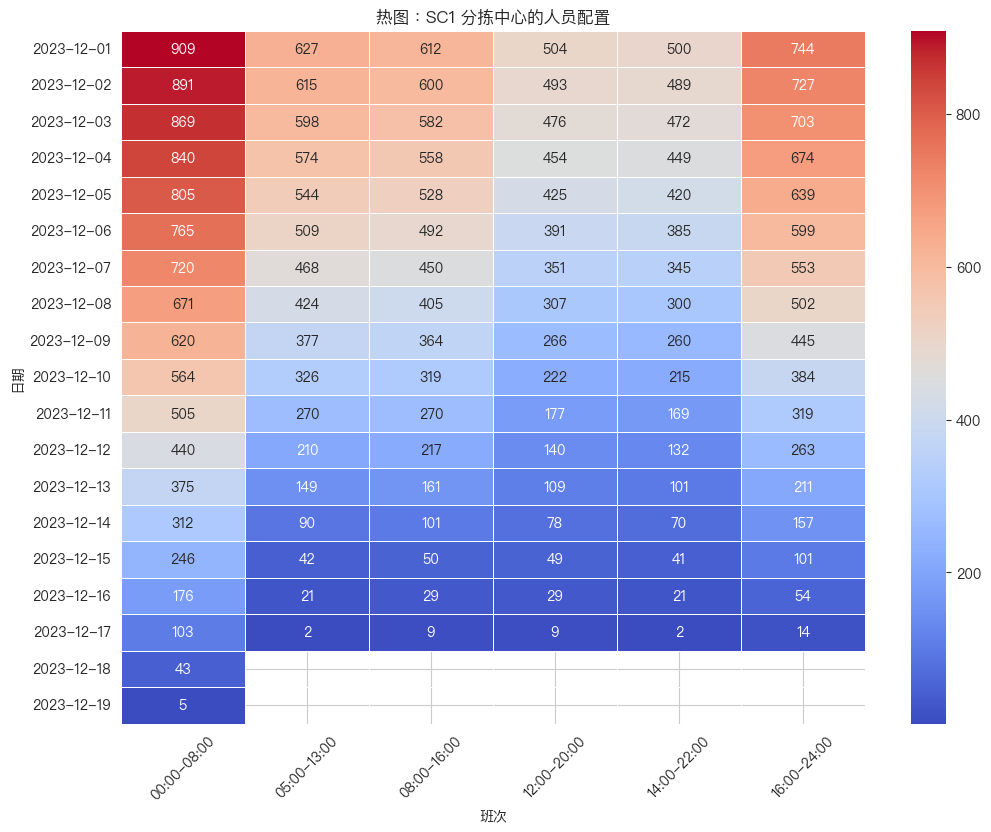

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

font_path = '/System/Library/Fonts/PingFang.ttc'
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # 使用支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

result_df = pd.read_csv('result_table_5.1.csv')
result_df['日期'] = pd.to_datetime(result_df['日期']).dt.date

# 计算每个班次的总人数
result_df['总人数'] = result_df['正式工人数'] + result_df['临时工人数']

# 选择一个分拣中心进行可视化
center_to_visualize = 'SC1'
center_data = result_df[result_df['分拣中心'] == center_to_visualize]

pivot_table = center_data.pivot(index="日期", columns="班次", values="总人数")

plt.figure(figsize=(12, 9))
sns.heatmap(pivot_table, annot=True, fmt="g", cmap="coolwarm", linewidths=.5)
plt.title(f'热图：{center_to_visualize} 分拣中心的人员配置') 
plt.ylabel('日期')
plt.xlabel('班次') 
plt.xticks(rotation=45)
plt.show()


/var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/ipykernel_29256/1587520768.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['日期'] = pd.to_datetime(filtered_data['日期']).dt.date
/var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/ipykernel_29256/1587520768.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['总人数'] = filtered_data['正式工人数'] + filtered_data['临时工人数']


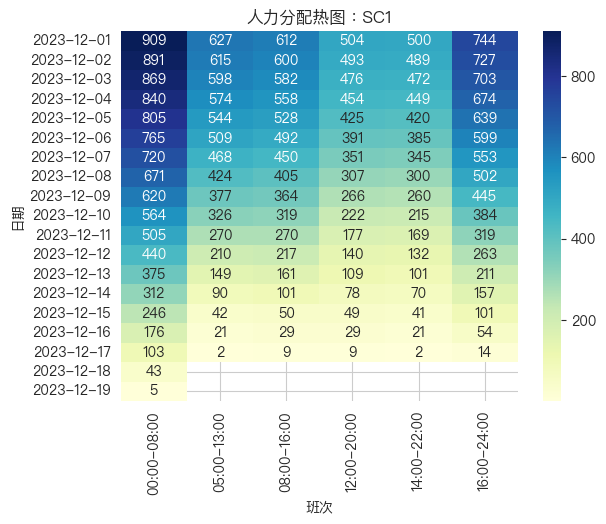

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


center_to_visualize = 'SC1'
filtered_data = result_df[result_df['分拣中心'] == center_to_visualize]
filtered_data['日期'] = pd.to_datetime(filtered_data['日期']).dt.date

filtered_data['总人数'] = filtered_data['正式工人数'] + filtered_data['临时工人数']

pivot_table = filtered_data.pivot_table(index='日期', columns='班次', values='总人数', aggfunc='sum')

sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title(f'人力分配热图：{center_to_visualize}')
plt.xlabel('班次')
plt.ylabel('日期')
plt.show()


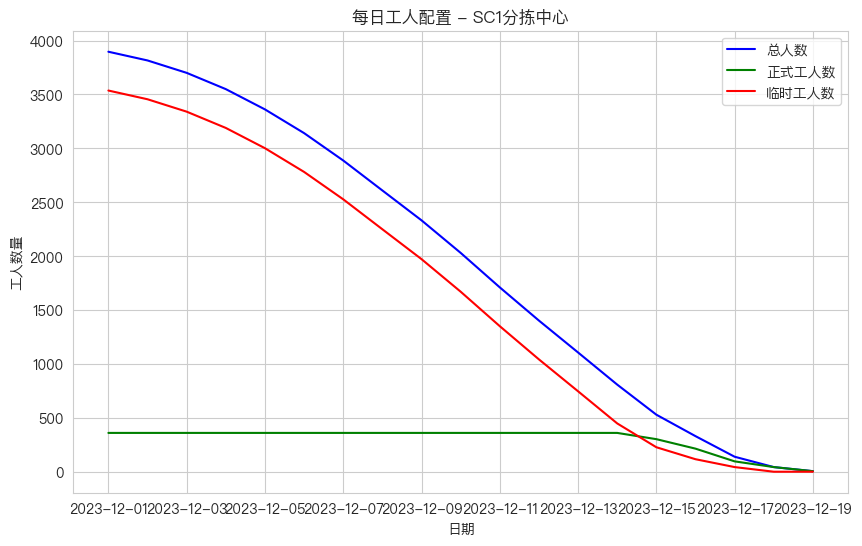

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

font_path = '/System/Library/Fonts/PingFang.ttc'
plt.rcParams['font.sans-serif'] = ['PingFang HK']  
plt.rcParams['axes.unicode_minus'] = False 

df = pd.read_csv('result_table_5.1.csv') 
df['日期'] = pd.to_datetime(df['日期'])

center_data = df[df['分拣中心'] == 'SC1']

daily_totals = center_data.groupby('日期').agg({'正式工人数': 'sum', '临时工人数': 'sum'})
daily_totals['总人数'] = daily_totals['正式工人数'] + daily_totals['临时工人数']

plt.figure(figsize=(10, 6))
plt.plot(daily_totals.index, daily_totals['总人数'], label='总人数', color='blue')
plt.plot(daily_totals.index, daily_totals['正式工人数'], label='正式工人数', color='green')
plt.plot(daily_totals.index, daily_totals['临时工人数'], label='临时工人数', color='red')
plt.title('每日工人配置 - SC1分拣中心')
plt.xlabel('日期')
plt.ylabel('工人数量')
plt.legend()
plt.grid(True)
plt.show()


/Users/yooky/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ng/h1_4zcsj2qq895j6xpxvjyqh0000gn/T/ipykernel_29256/2448705857.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


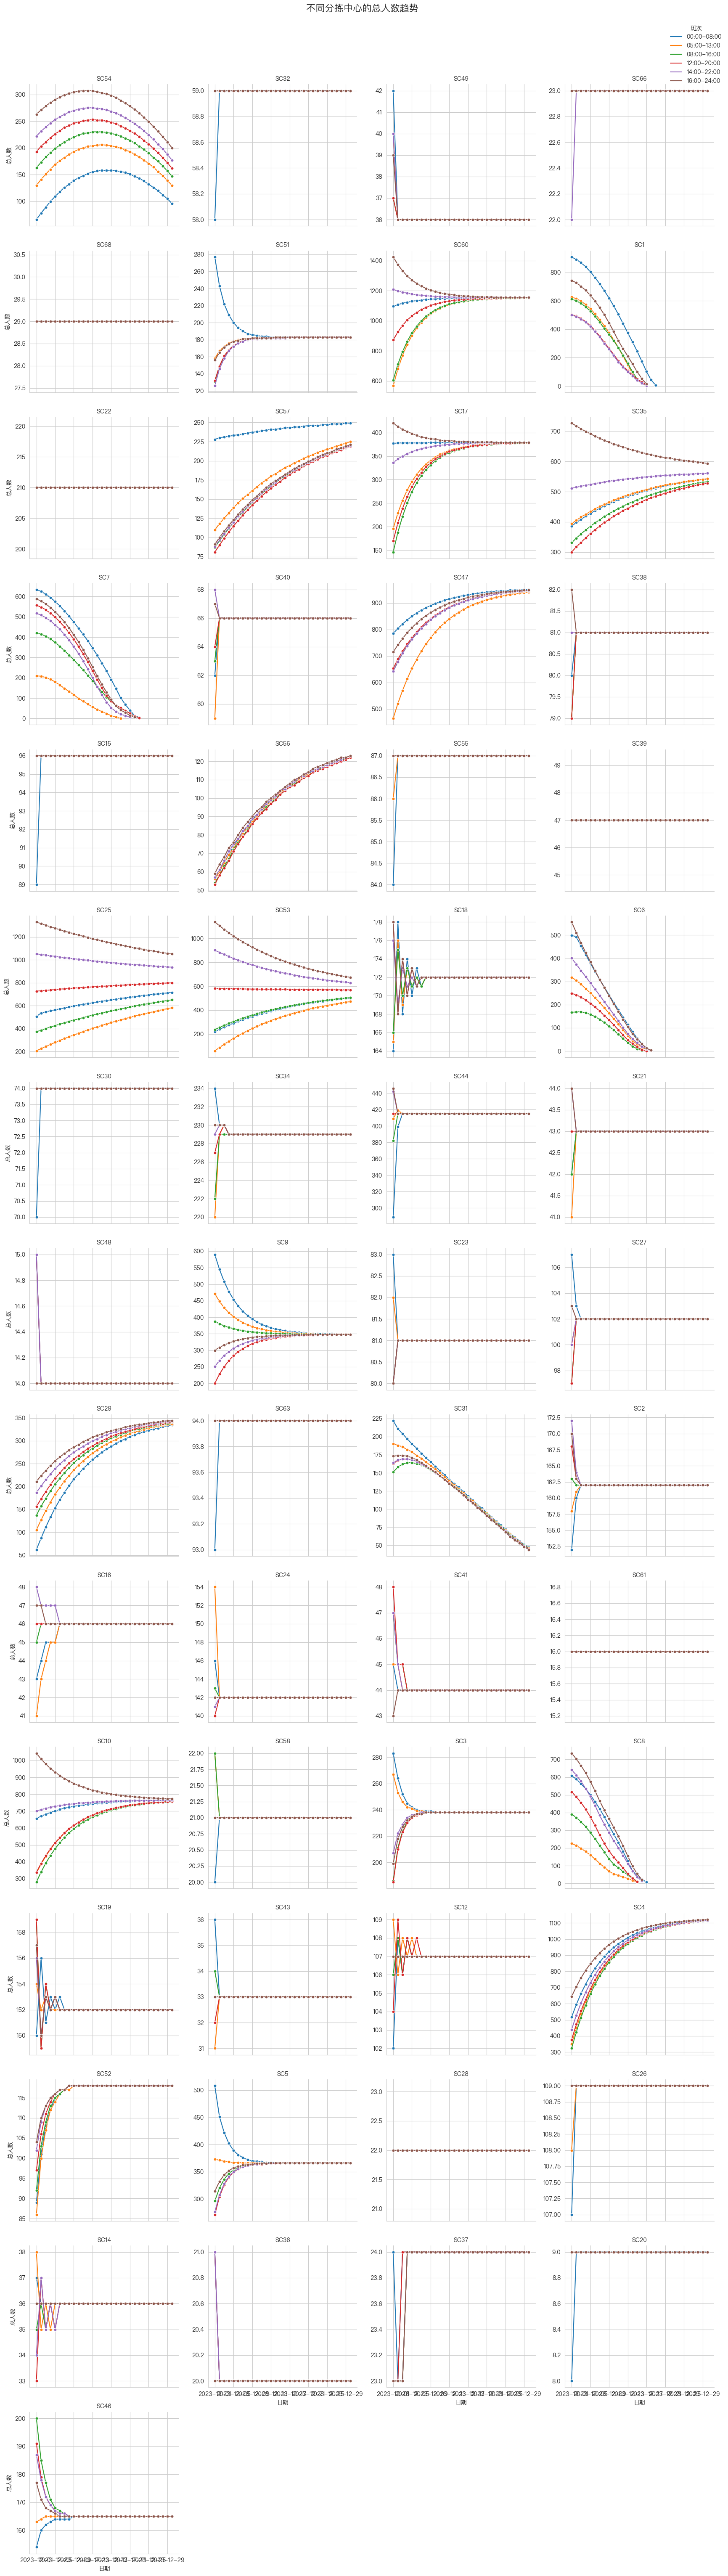

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

result_df = pd.read_csv('result_table_5.1.csv')

result_df['日期'] = pd.to_datetime(result_df['日期'])

result_df['总人数'] = result_df['正式工人数'] + result_df['临时工人数']

g = sns.FacetGrid(result_df, col='分拣中心', col_wrap=4, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='日期', y='总人数', hue='班次', marker='o', markersize=5, palette='tab10')
g.set_titles('{col_name}')
g.set_xlabels('日期')
g.set_ylabels('总人数')
g.add_legend(title='班次', bbox_to_anchor=(1, 1))
plt.suptitle('不同分拣中心的总人数趋势', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


# 写作要点
- **线性规划 (Linear Programming)**
- **整数规划 (Integer Programming)**
- **PuLP (一个Python库)**
- **除此之外，把上面提到的文字叙述的公式，转换成数学符号，记得在文前介绍你的数学符号意义**